# Introduction

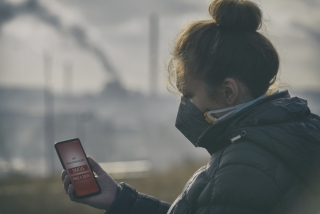

According to the article "Air pollution: The silent killer called PM2.5" (https://www.mcgill.ca/newsroom/channels/news/air-pollution-silent-killer-called-pm25-329428)

"Among the different types of air pollution, PM2.5 kills the most people worldwide. It consists of particles smaller than approximately 2.5 microns – so small that billions of them can fit inside a red blood cell.

More than half of the world urgently needs protection in the form of adequate PM2.5 ambient air quality standards. Putting these standards in place everywhere will save countless lives. And where standards are already in place, they should be harmonized globally."

So it is very important for us to predict and prevent PM2.5. In thia notebook, I tried to find prediction model by LSTM.

Image and reference : "Air pollution: The silent killer called PM2.5" (https://www.mcgill.ca/newsroom/channels/news/air-pollution-silent-killer-called-pm25-329428)


Thank you very much for sharing !

# Importing and Preprocessing

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/air-quality-data-in-india/air-quality-india.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime

import math
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
plt.style.use("fivethirtyeight")
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [3]:
df=pd.read_csv('/kaggle/input/air-quality-data-in-india/air-quality-india.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36192 entries, 0 to 36191
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  36192 non-null  object 
 1   Year       36192 non-null  int64  
 2   Month      36192 non-null  int64  
 3   Day        36192 non-null  int64  
 4   Hour       36192 non-null  int64  
 5   PM2.5      36192 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.7+ MB


In [5]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

In [6]:
df.head()

,Timestamp,Year,Month,Day,Hour,PM2.5
0,2017-11-07 12:00:00,2017,11,7,12,64.51
1,2017-11-07 13:00:00,2017,11,7,13,69.95
2,2017-11-07 14:00:00,2017,11,7,14,92.79
3,2017-11-07 15:00:00,2017,11,7,15,109.66
4,2017-11-07 16:00:00,2017,11,7,16,116.50


In [7]:
df['Date']=df["Timestamp"].dt.date

# Visualization

* Time series by days

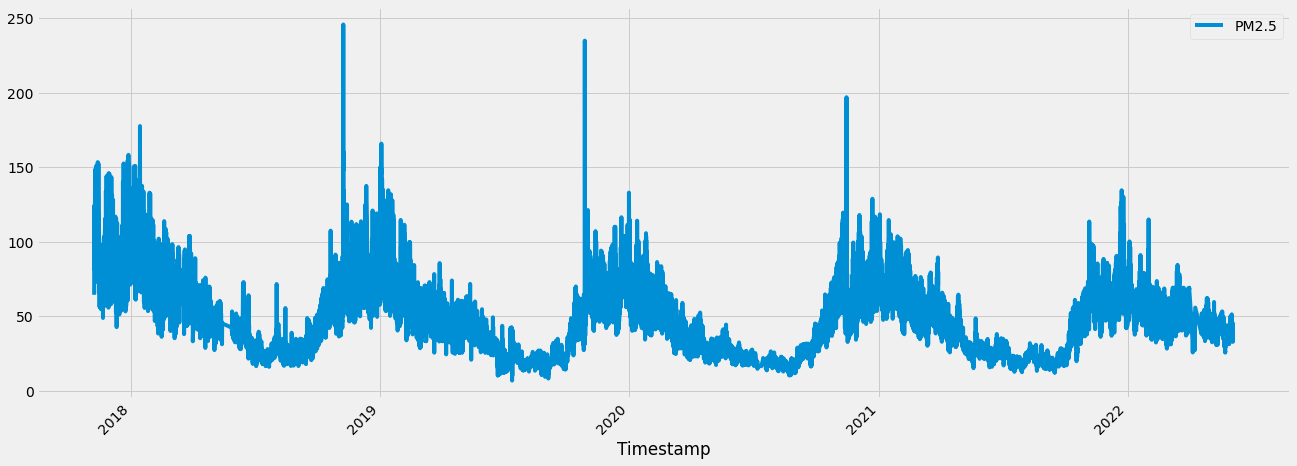

In [8]:
df.plot(x='Timestamp',y='PM2.5',figsize=(20,8))
plt.xticks(rotation=45)

plt.show()

* Time series by year average

<AxesSubplot:xlabel='Year'>

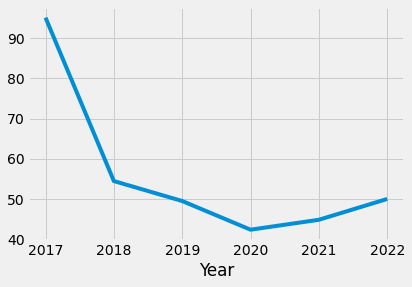

In [9]:
df.groupby('Year')['PM2.5'].mean().plot()

* Boxplot by year

<AxesSubplot:xlabel='Year', ylabel='PM2.5'>

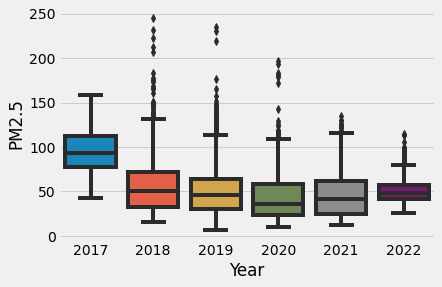

In [10]:
df_year=df.loc[:,['Year','PM2.5']]
sns.boxplot(x='Year', y='PM2.5',data=df_year)

* Time series by month average

<AxesSubplot:xlabel='Month'>

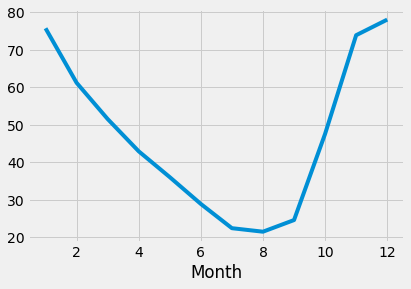

In [11]:
df.groupby('Month')['PM2.5'].mean().plot()

* Boxplot by month

<AxesSubplot:xlabel='Month', ylabel='PM2.5'>

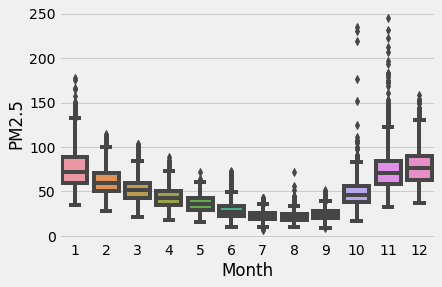

In [12]:
df_month=df.loc[:,['Month','PM2.5']]
sns.boxplot(x='Month', y='PM2.5',data=df_month)

* Time series by day average

<AxesSubplot:xlabel='Day'>

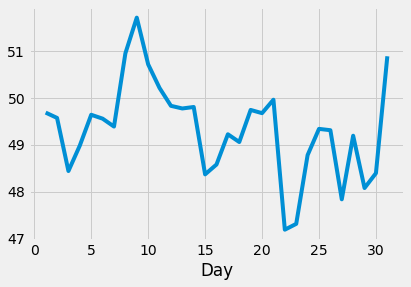

In [13]:
df.groupby('Day')['PM2.5'].mean().plot()

* Boxplot by day

<AxesSubplot:xlabel='Day', ylabel='PM2.5'>

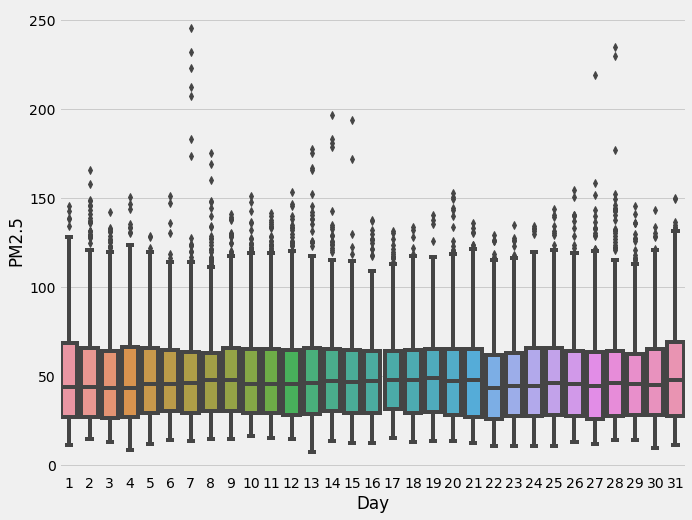

In [14]:
df_day=df.loc[:,['Day','PM2.5']]
plt.figure(figsize=(10,8))
sns.boxplot(x='Day', y='PM2.5',data=df_day)

* Time series by hour average

<AxesSubplot:xlabel='Hour'>

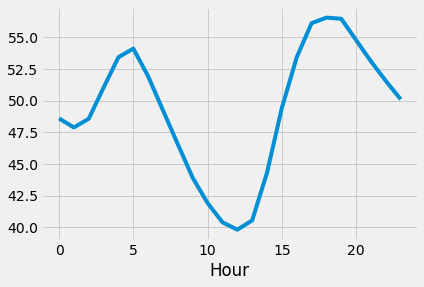

In [15]:
df.groupby('Hour')['PM2.5'].mean().plot()

* Boxplot by hour

<AxesSubplot:xlabel='Hour', ylabel='PM2.5'>

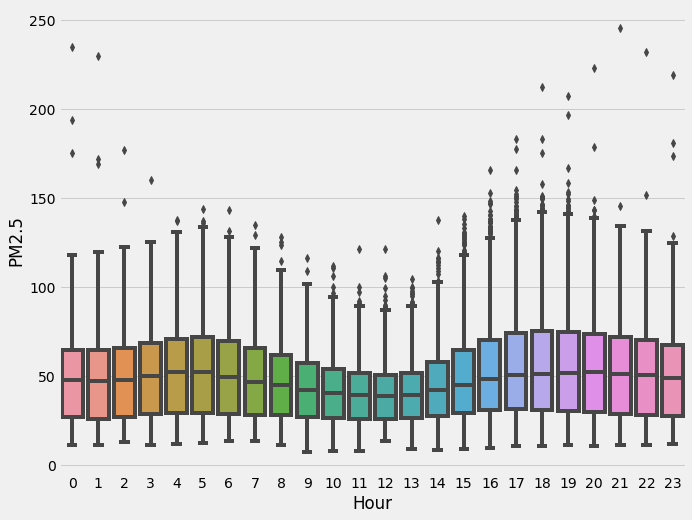

In [16]:
df_hour=df.loc[:,['Hour','PM2.5']]
plt.figure(figsize=(10,8))
sns.boxplot(x='Hour', y='PM2.5',data=df_hour)

# Prediction Model

* I tried to find the prediction model by each days average. So first, I made each days average data set.

In [17]:
df_date=pd.DataFrame(df.groupby('Date')['PM2.5'].mean())
df_date

,PM2.5
Date,
2017-11-07,99.805833
2017-11-08,110.979565
2017-11-09,114.915833
2017-11-10,119.404091
2017-11-11,109.267273
...,...
2022-05-31,41.465417
2022-06-01,41.645833
2022-06-02,42.255417


* Time series by each days average

<AxesSubplot:xlabel='Date'>

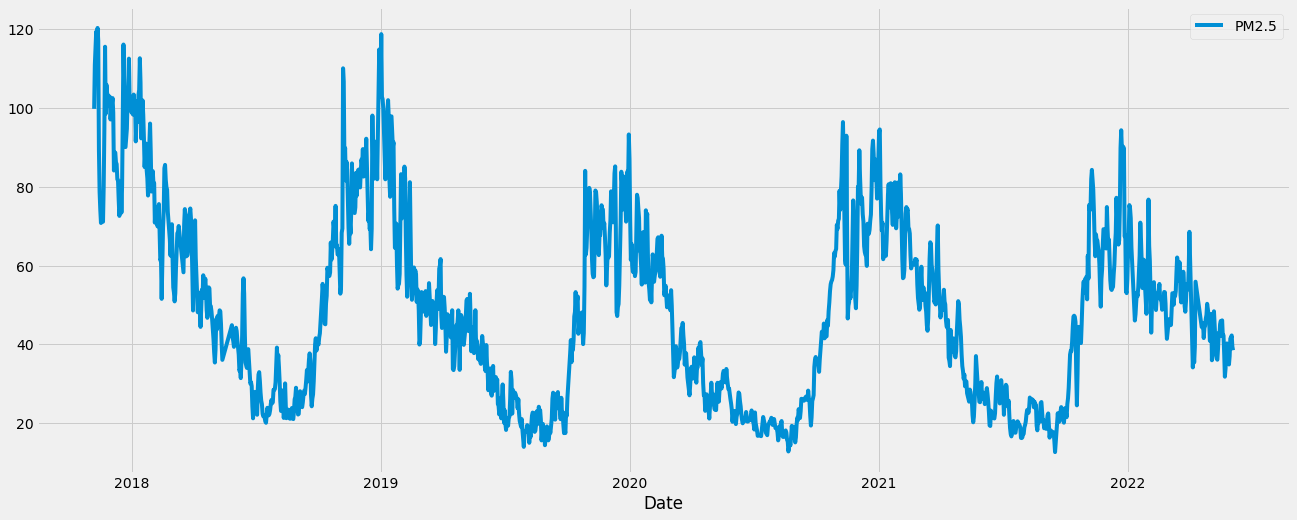

In [18]:
df_date.plot(figsize=(20,8))

* Split data into train 80% and test 20%

In [19]:
dataset  = df_date.values
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

1293

* Standardization by MinMaxScaler

In [20]:
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)
scaled_data

array([[0.80924161],
       [0.91297267],
       [0.94951492],
       ...,
       [0.27497376],
       [0.24870153],
       [0.24014526]])

In [21]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
num = 60
for i in range(num, len(train_data)):
    x_train.append(train_data[i-num:i , 0])
    y_train.append(train_data[i , 0])

In [22]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1233, 60, 1)

* Modeling

In [23]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

2022-06-12 07:52:05.759461: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [24]:
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [25]:
model.fit(x_train,y_train, batch_size=1, epochs=1)

2022-06-12 07:52:06.434253: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1233/1233 [==============================] - 36s 27ms/step - loss: 0.0071


* Prediction

In [26]:
test_data = scaled_data[training_data_len-60: , :]
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(num, len(test_data)):
      x_test.append(test_data[i-num:i, 0])

In [27]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [28]:
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

In [29]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1.6820399806264188

In [30]:
train = df_date[:training_data_len]
valid = df_date[training_data_len:]
valid["Predictions"] = predictions
valid

,PM2.5,Predictions
Date,,
2021-06-28,28.667917,27.062656
2021-06-29,30.903750,26.962961
2021-06-30,29.017917,27.623934
2021-07-01,27.166667,27.954317
2021-07-02,27.132917,27.701321
...,...,...
2022-05-31,41.465417,36.027596
2022-06-01,41.645833,37.145634
2022-06-02,42.255417,38.359730


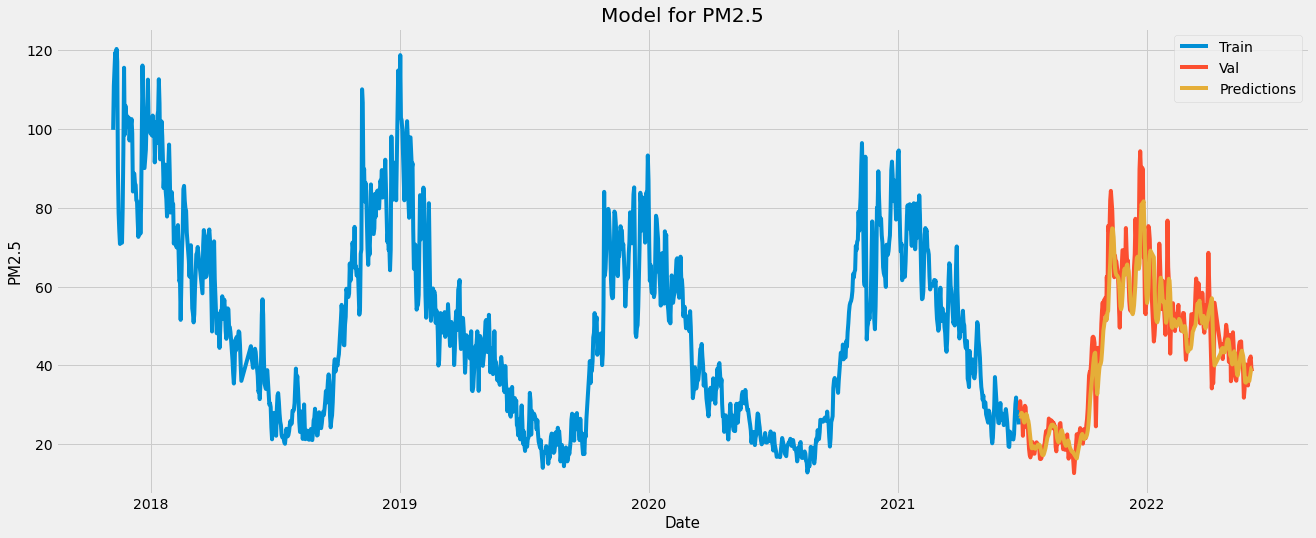

In [31]:
plt.figure(figsize=(20,8))
plt.title("Model for PM2.5")
plt.xlabel("Date", fontsize = 15)
plt.ylabel("PM2.5",fontsize=15)
plt.plot(train[df_date.columns])
plt.plot(valid['PM2.5'])
plt.plot(valid["Predictions"])
plt.legend(["Train","Val","Predictions"])

Thank you !